# *RustyInsights*

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Descripción de los datos
El dataset está almacenado en el archivo `/datasets/car_data.csv`

Características:

* `DateCrawled`: Fecha en la que se descargó el perfil de la base de datos
* `VehicleType`: Tipo de carrocería del vehículo
* `RegistrationYear`: El año de matriculación del vehículo
* `Gearbox`: Tipo de caja de cambios
* `Power`: La potencia (CV)
* `Model`: EL modelo del vehículo
* `Mileage`: El kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
* `RegistrationMonth`:El mes de matriculación del vehículo
* `FuelType`: El tipo de combustible
* `Brand`: La marca del vehículo
* `NotRepaired`: Vehículo con o sin reparación
* `DateCreated`: La fecha de creación del perfil
* `NumberOfPictures`: El número de fotos del vehículo
* `PostalCode`: El código postal del propietario del perfil (usuario)
* `LastSeen`: La fecha de la última vez que el usuario estuvo activo

Objetivo:

* `Price`: El precio, que esta en euros. 

## Preparación de datos

###  INICIALIZACIÓN

In [1]:
# Cargar todas las librerías a usar en el proyecto. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importa la función de cálculo del EMC y el R2 desde la librería scikit-learn
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Importar la función train_test_split desde la librería sklearn 
from sklearn.model_selection import train_test_split

# Importar la función del Bosque aleatorio 
from sklearn.ensemble import RandomForestClassifier

# Importar la función de la Regresión Linear
from sklearn.linear_model import LinearRegression


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

#Importar la función de Escalado de características
from sklearn.preprocessing import StandardScaler

#Importar la función de OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from catboost import CatBoostRegressor 
import xgboost as xgb

# Medición del tiempo de ejecución
import time

### CARGAR LOS DATOS.

In [2]:
data  = pd.read_csv('/datasets/car_data.csv')
print(f'\n Datos cargados correctamente. Con la siguiente Dimensión: {data.shape}')


 Datos cargados correctamente. Con la siguiente Dimensión: (354369, 16)


### ANÁLISIS DE LOS DATOS

In [3]:
print("\nInformación general del DataFrame:")
data.info()
print()
print("\n Estadísitica descriptiva")
data.describe()


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-nu

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
# Obtención de las 10 primeras filas de las bases de datos 
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [5]:
# Eliminar columnas irrelevantes
data_clean = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen', 'DateCreated'], axis = 1)

In [6]:
#Filtrar el año entre 1960 a 2024
data_clean = data_clean[(data_clean['RegistrationYear'] > 1960) & (data_clean['RegistrationYear'] <= 2023)] 

In [7]:
#Comprobación del cambio en RegistrionYear
data_clean['RegistrationYear'].describe()

count    353654.000000
mean       2003.173031
std           7.159601
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [8]:
#Selección de poder mayores a 20
data_clean = data_clean[(data_clean['Power'] > 20) & (data_clean['Power'] <= 20000)] 

In [9]:
#Comprobación del cambio en Power 
data_clean['Power'].describe()

count    313463.000000
mean        124.308531
std         197.007333
min          21.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

Como se puede visualizar en esta tabla el minimo de 'Power' es 20 y esto nos ayudara a tener mejor analisis. 

In [10]:
data_clean.reset_index(inplace = True)

In [11]:
#Comprobación del cambio 
data_clean.info()
print()
print()
data_clean.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313463 entries, 0 to 313462
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              313463 non-null  int64 
 1   Price              313463 non-null  int64 
 2   VehicleType        290719 non-null  object
 3   RegistrationYear   313463 non-null  int64 
 4   Gearbox            307013 non-null  object
 5   Power              313463 non-null  int64 
 6   Model              300362 non-null  object
 7   Mileage            313463 non-null  int64 
 8   RegistrationMonth  313463 non-null  int64 
 9   FuelType           292339 non-null  object
 10  Brand              313463 non-null  object
 11  NotRepaired        263933 non-null  object
dtypes: int64(6), object(6)
memory usage: 28.7+ MB




,index,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,313463.000000,313463.000000,313463.000000,313463.000000,313463.000000,313463.000000
mean,177222.843962,4702.456443,2003.290487,124.308531,128636.298383,5.936337
std,102211.784633,4589.194853,6.840860,197.007333,36653.842688,3.615655
min,1.000000,0.000000,1961.000000,21.000000,5000.000000,0.000000
25%,88806.500000,1250.000000,1999.000000,75.000000,125000.000000,3.000000
50%,177221.000000,2999.000000,2003.000000,110.000000,150000.000000,6.000000
75%,265704.500000,6870.000000,2008.000000,150.000000,150000.000000,9.000000
max,354368.000000,20000.000000,2019.000000,20000.000000,150000.000000,12.000000


In [12]:
#Coimprobación de valores ausentes 
print('\n Valores nulos por columna:')
print(data_clean.isna().sum()) 


 Valores nulos por columna:
index                    0
Price                    0
VehicleType          22744
RegistrationYear         0
Gearbox               6450
Power                    0
Model                13101
Mileage                  0
RegistrationMonth        0
FuelType             21124
Brand                    0
NotRepaired          49530
dtype: int64


In [13]:
#Cambiar los valores nulos a desconocidos 
data_clean.fillna('Desconocido', inplace = True)

In [14]:
#Coimprobación del cambio 
print('\n Valores nulos por columna:')
print(data_clean.isna().sum()) 


 Valores nulos por columna:
index                0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64


In [15]:
#Verificación de que no haya duplicado. 
print(f'\nSe encontró que hay {data_clean.duplicated().sum()} datos duplicados en el DataFrame')


Se encontró que hay 0 datos duplicados en el DataFrame


### GRÁFICAS 

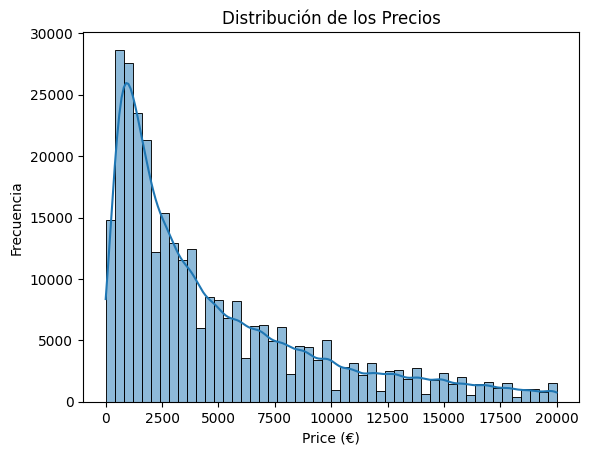

In [16]:
#Analisis de la distribucción de los  precios 

# Filtrar los valores donde el precio no sea 0
data_clean_filtered = data_clean[data_clean['Price'] != 0]

# Graficar la distribución de precios
sns.histplot(data_clean_filtered['Price'], bins=50, kde=True)
plt.title("Distribución de los Precios")
plt.xlabel("Price (€)")
plt.ylabel("Frecuencia")
plt.show()

Con la gráfica que se obtuvo de la distribucción de los precios. En este se puede apreciar que la gráfica tiene una distribucción asimétrica sesgada hacia la derecha y esto puede significar que los precios de los vehiculos que tiene la empresa Rusty son bajos y hay muy pocos con precio alto. 

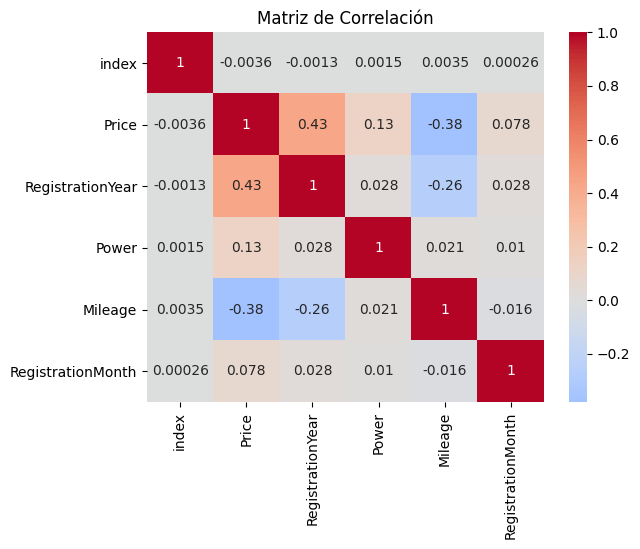

In [17]:
#Matriz Correlación 
corr_matrix = data_clean.corr() 

#Creacción de un mapa de calor para visualizar la matriz de correlación
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de Correlación')
plt.show()

#Referencia: https://www.analyticslane.com/2023/07/27/graficos-de-correlacion-en-seaborn-mapas-de-calor-y-graficos-de-pares/

Se puede observar en la siguiente gráfica de que `'Mileage'`, `'RegistrationYear'` y `'Power'` son las tres variables que influyen pero de una manera mederada en el precio.
En el caso de `'Mileage'` este tiene una correlación negativa moderada con un valor de -0.33. Esto puede sugerir entre más kilometraje tenga el vehiculo, el precio de este disminuira. 
Por el otro lado `'Power'` este tiene una correlación positiva débil con un valor de 0.16. Esto puede sugerir que los vehiculos con mayor potencia tienden a ser más costosos pero esto no es una relación fuerte. 
Por el otro lado `'RegistrationYear'` este tiene una corelación mayor positiva con un valor de 0.43. 

## Entrenamiento del modelo 

### CODIFICACIÓN One-Hot

In [18]:
#Selección de los datos categoricos 
characteristics_c= list(data_clean.dtypes[data_clean.dtypes == 'object'].index)
characteristics_c

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [19]:
for characteristics in characteristics_c: 
    print(data_clean[characteristics_c].value_counts())
    print()
    print()

VehicleType  Gearbox      Model   FuelType     Brand       NotRepaired
sedan        manual       golf    petrol       volkswagen  no             7319
small        manual       corsa   petrol       opel        no             5820
                          polo    petrol       volkswagen  no             5636
sedan        manual       3er     petrol       bmw         no             3565
small        manual       fiesta  petrol       ford        no             2654
                                                                          ... 
             Desconocido  a3      petrol       audi        yes               1
bus          manual       other   lpg          hyundai     Desconocido       1
small        Desconocido  a3      gasoline     audi        Desconocido       1
                          a1      petrol       audi        no                1
Desconocido  Desconocido  100     Desconocido  audi        Desconocido       1
Length: 15502, dtype: int64


VehicleType  Gearbox      Mode

In [20]:
data_clean_ohe = data_clean.drop(['Model', 'Brand'], axis = 1 )

In [21]:
data_clean_ohe = pd.get_dummies(data_clean_ohe, drop_first = True)

In [22]:
data_clean_ohe.head()

,index,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Gearbox_manual,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_yes
0,1,18300,2011,190,125000,5,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,2,9800,2004,163,125000,8,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1500,2001,75,150000,6,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,4,3600,2008,69,90000,7,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,5,650,1995,102,150000,10,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [23]:
data_clean[['Brand', 'Model']] = OrdinalEncoder().fit_transform(data_clean[['Brand', 'Model']])

In [24]:
data_clean

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,1,18300,coupe,2011,manual,190,26.0,125000,5,gasoline,1.0,yes
1,2,9800,suv,2004,auto,163,118.0,125000,8,gasoline,14.0,Desconocido
2,3,1500,small,2001,manual,75,117.0,150000,6,petrol,38.0,no
3,4,3600,small,2008,manual,69,102.0,90000,7,gasoline,31.0,no
4,5,650,sedan,1995,manual,102,11.0,150000,10,petrol,2.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
313458,354361,5250,Desconocido,2016,auto,150,4.0,150000,12,Desconocido,0.0,no
313459,354362,3200,sedan,2004,manual,225,141.0,150000,5,petrol,30.0,yes
313460,354366,1199,convertible,2000,auto,101,107.0,125000,3,petrol,32.0,no
313461,354367,9200,bus,1996,manual,102,224.0,150000,3,gasoline,38.0,no


In [25]:
data_clean_encode = pd.get_dummies(data_clean, drop_first = True)

In [26]:
data_clean_encode

,index,Price,RegistrationYear,Power,Model,Mileage,RegistrationMonth,Brand,VehicleType_bus,VehicleType_convertible,...,Gearbox_manual,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_yes
0,1,18300,2011,190,26.0,125000,5,1.0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,2,9800,2004,163,118.0,125000,8,14.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1500,2001,75,117.0,150000,6,38.0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,4,3600,2008,69,102.0,90000,7,31.0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,5,650,1995,102,11.0,150000,10,2.0,0,0,...,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313458,354361,5250,2016,150,4.0,150000,12,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
313459,354362,3200,2004,225,141.0,150000,5,30.0,0,0,...,1,0,0,0,0,0,0,1,0,1
313460,354366,1199,2000,101,107.0,125000,3,32.0,0,1,...,0,0,0,0,0,0,0,1,1,0
313461,354367,9200,1996,102,224.0,150000,3,38.0,1,0,...,1,0,0,1,0,0,0,0,1,0


In [27]:
#Selección de los datos categoricos 
numeric= list(data_clean.dtypes[data_clean.dtypes == 'int64'].index)
numeric

['index', 'Price', 'RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']

In [28]:
#Creación de una instacia de StandarScales 
scaler = StandardScaler()

#Identificación de comunas numéricas 
numeric_columns = ['Price', 'RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']

#Ajustar el escalado y transformación de las columnas numéricas 
data_clean[numeric_columns] = scaler.fit_transform(data_clean[numeric_columns])

#Verificación del cambio 
data_clean.head() 

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,1,2.962952,coupe,1.126982,manual,0.333447,26.0,-0.099207,-0.258968,gasoline,1.0,yes
1,2,1.110773,suv,0.103717,auto,0.196396,118.0,-0.099207,0.570759,gasoline,14.0,Desconocido
2,3,-0.697826,small,-0.334825,manual,-0.250288,117.0,0.582851,0.017608,petrol,38.0,no
3,4,-0.240229,small,0.688440,manual,-0.280744,102.0,-1.054088,0.294183,gasoline,31.0,no
4,5,-0.883044,sedan,-1.211909,manual,-0.113237,11.0,0.582851,1.123909,petrol,2.0,yes


In [29]:
#Dividir el datset
train_valid, test = train_test_split(data_clean_encode, test_size = 0.20, random_state = 12345)
train, valid = train_test_split(train_valid, test_size = 0.25)

In [30]:
#Verificación del tamaño de cada conjunto 
print(f'El tamaño del conjunto de entrenamiento es de {train.shape}')
print(f'El tamaño del conjunto de validación {valid.shape}')
print(f'El tamaño del conjunto de prueba {test.shape}')

El tamaño del conjunto de entrenamiento es de (188077, 27)
El tamaño del conjunto de validación (62693, 27)
El tamaño del conjunto de prueba (62693, 27)


In [31]:
# Dividir las características y el objetivo para cada conjunto
features_train = train.drop(columns=['Price'])
targets_train = train['Price']

features_valid = valid.drop(columns=['Price'])
targets_valid = valid['Price']

features_test = test.drop(columns=['Price'])
targets_test = test['Price']

# Modelo de Regresión Lineal 

In [32]:

model_lr = LinearRegression() 


# Entrenamiento del modelo y medición del tiempo
start_time = time.time()
model_lr.fit(features_train, targets_train)
end_time = time.time()

training_time = end_time - start_time


#Predicciones 
start_time_pred = time.time()
predictions_valid = model_lr.predict(features_valid)
end_time_pred = time.time()
predict_time = end_time_pred - start_time_pred

#Calculo de RMSE 
mse= mean_squared_error(targets_valid, predictions_valid)

rmse = np.sqrt(mse)

print("Regresión Lineal")
print("Tiempo de entrenamiento:", training_time)
print(f"El RMSE es de {rmse}")
print(f"Tiempo de predicción:{predict_time}")

Tiempo de entrenamiento: 0.1023249626159668
Regresión Lineal
El RMSE es de 3187.27138540912
Tiempo de predicción:0.07831549644470215


# Decision Tree

In [33]:

# Separar características y objetivos para train_valid y test
features_train_valid = train_valid.drop(columns=['Price'])
targets_train_valid = train_valid['Price']

features_test = test.drop(columns=['Price'])
targets_test = test['Price']

# Definición del modelo
model_tree = DecisionTreeRegressor(random_state=12345)

# Definición de parámetros para RandomizedSearchCV
param_dist = {
    'criterion' : ["friedman_mse", "mse"],
    'splitter' : ["best", "random"],
    "max_depth" : [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}

# Definir el escore basado en RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_tree,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring=scorer,
    cv=5,  # Número de folds de cross-validation
    n_jobs=-1,  # Usar todos los núcleos disponibles
    random_state=12345
)

# Ajustar el RandomizedSearchCV
start_time = time.time()
random_search.fit(features_train_valid, targets_train_valid)
end_time = time.time()

# Obtener los mejores parámetros 
best_params = random_search.best_params_

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Obtener predicciones del mejor modelo en el conjunto de validación
start_time_pred = time.time()
predictions_valid_ohe = best_model.predict(features_test)
end_time_pred = time.time()

# Calculo de RMSE
rmse = np.sqrt(mean_squared_error(targets_test, predictions_valid))

predict_time = end_time_pred - start_time_pred
training_time = end_time - start_time

# Mostrar resultados
print("Deccision Tree")
print("Mejores parámetros: ", best_params)
print("Root Mean Squared Error:", rmse)
print("Tiempo de entrenamiento:", training_time)
print("Tiempo de predicción:", predict_time)

Deccision Tree
Mejores parámetros:  {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 20, 'criterion': 'mse'}
Root Mean Squared Error: 5652.3610104741865
Tiempo de entrenamiento: 88.22712087631226
Tiempo de predicción: 0.015276432037353516


# LightGBM

In [34]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=12345)
start_time = time.time()
lgb_model.fit(features_train, targets_train)
lgb_train_time = time.time() - start_time

start_time = time.time()
lgb_predictions = lgb_model.predict(features_valid)
lgb_pred_time = time.time() - start_time

lgb_rmse = mean_squared_error(targets_valid, lgb_predictions, squared=False)
print(f"LightGBM - RMSE: {lgb_rmse}, Training Time: {lgb_train_time}, Prediction Time: {lgb_pred_time}")

LightGBM - RMSE: 1805.7784046838417, Training Time: 2.82635760307312, Prediction Time: 0.31023406982421875


# XGBoost

In [35]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=12345)
start_time = time.time()
xgb_model.fit(features_train, targets_train)
xgb_train_time = time.time() - start_time

start_time = time.time()
xgb_predictions = xgb_model.predict(features_valid)
xgb_pred_time = time.time() - start_time

xgb_rmse = mean_squared_error(targets_valid, xgb_predictions, squared=False)
print(f"XGBoost - RMSE: {xgb_rmse}, Training Time: {xgb_train_time}, Prediction Time: {xgb_pred_time}")

XGBoost - RMSE: 1805.918175701161, Training Time: 34.78739380836487, Prediction Time: 0.19098114967346191


# CatBoost

In [36]:
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=12345, verbose=0)
start_time = time.time()
cat_model.fit(features_train, targets_train)
cat_train_time = time.time() - start_time

start_time = time.time()
cat_predictions = cat_model.predict(features_valid)
cat_pred_time = time.time() - start_time

cat_rmse = mean_squared_error(targets_valid, cat_predictions, squared=False)
print(f"CatBoost - RMSE: {cat_rmse}, Training Time: {cat_train_time}, Prediction Time: {cat_pred_time}")


CatBoost - RMSE: 1923.5337561979898, Training Time: 2.2629148960113525, Prediction Time: 0.009569168090820312


## Análisis del modelo

Tras evaluar diferentes modelos de regresión para predecir el valor de mercado de coches de segunda mano, se han obtenido los siguientes hallazgos clave:

Regresión Lineal:

* Ventaja: Es el modelo más rápido de entrenar (0.10s) y tiene un tiempo de predicción relativamente bajo.

* Desventaja: Aunque su RMSE (3187.27) es aceptable, hay modelos más precisos.

Árbol de Decisión:

* Ventaja: Permite interpretabilidad y ajuste de hiperparámetros.

* Desventaja: Su RMSE (5652.36) es el peor de todos, lo que indica sobreajuste o falta de generalización. Además, su tiempo de entrenamiento (88.22s) es excesivo en comparación con otros modelos.

Boosting (LightGBM, XGBoost, CatBoost): 

* LightGBM fue el mejor modelo en términos de precisión (RMSE: 1805.77) con un tiempo de entrenamiento moderado (2.83s).

* XGBoost logró un RMSE similar (1805.91), pero con un tiempo de entrenamiento significativamente más alto (34.79s).

* CatBoost también fue competitivo (RMSE: 1923.53), con el entrenamiento más rápido de los tres (2.26s) y la predicción más rápida (0.009s).

Recomendaciones: 

* LightGBM es la mejor opción para este problema, ya que equilibra bien precisión y velocidad.
* XGBoost no aporta mejoras significativas en RMSE y es más lento, por lo que no es la mejor elección aquí.
* CatBoost es una buena alternativa si se prioriza la velocidad de predicción.
* Árbol de decisión no es recomendable debido a su alto RMSE.

## Referencia 

Rodríguez, D. (2023, 9 julio). Gráficos de correlación en Seaborn: Mapas de calor y gráficos de pares. Analytics Lane. https://www.analyticslane.com/2023/07/27/graficos-de-correlacion-en-seaborn-mapas-de-calor-y-graficos-de-pares/